In [1]:
import sys
sys.path.append('../data')
sys.path.append('../data/low')
sys.path.append('../data/mid')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

In [2]:
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/high/"
fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]


### **low frames**

In [3]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)
        print(fname)

file10_080124.mat
file11_080124.mat
file12_080124.mat
file13_080124.mat
file15_080124.mat
file16_080124.mat
file17_080124.mat
file18_080124.mat
file1_050124.mat
file1_080124.mat
file2_050124.mat
file3_080124.mat
file7_080124.mat
file8_080124.mat
file9_080124.mat
low1_100124.mat
low2_100124.mat
low3_100124.mat
low5_100124.mat


In [4]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    taus.append(aux.get_tau()[1])
    sys.stdout.write(str(i) + '\r')

In [5]:
hilbert_frames = []
for i, df in enumerate(defectos_frames):
    aux, _ = df.get_hilbert()
    hilbert_frames.append(aux)
    sys.stdout.write(str(i) + '\r')

**dataframe con defectos**

In [6]:
# dataframe con defectos
frames_cd = []

for i in range(len(frames)):
    frames_cd.append(pd.merge(frames[i], hilbert_frames[i], on='Hilbert Transform', how='outer'))

frames_cd[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j,0.006356,2.487745,-0.050221
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j,0.004849,3.083952,-0.023636
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j,0.004634,3.123610,0.001438
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j,0.004582,3.407171,0.023619
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j,0.004419,3.453607,0.041826
...,...,...,...,...,...,...,...
599995,0.176268,0.058256,0.000015,0.000015+0.000493j,0.000493,30135.697377,-0.289769
599996,0.177254,0.059242,0.000033,0.000033+0.000343j,0.000345,30135.630801,-0.245612
599997,0.179227,0.061215,0.000050,0.000050+0.001284j,0.001285,30135.688260,-0.187389
599998,0.179885,0.061872,0.000066,0.000066+0.001095j,0.001097,30135.667052,-0.118399


**indices de los defectos**

In [15]:
# obtención de los indices de los defectos

defectos_indices = []
for elem in defectos_frames:
    indices, _ = elem.get_defectos()
    defectos_indices.append(indices)


129


In [17]:
# arreglo con los DataFrame que tienen los inicios, finales e indice tau de los defectos

tau_indices = []
for elem in defectos_frames:
    tau_indices.append(elem.get_tau_indices())


In [37]:
# arreglo con el inicio y final de los defectos
indices_defectos = []
for elem in tau_indices:
    x = elem[['start', 'end']]
    indices_defectos.append(x.values)

In [52]:
len(indices_defectos)

19

**funciones para ventanas**

In [67]:
def create_windows(df, size = 4000, overlap = 500):
    num_windows = (len(df) - size) // (size - overlap) + 1
    windows = []
    for i in range(num_windows):
        start = i * (size - overlap)
        end = start + size
        window = df.iloc[start:end]
        windows.append(window)
    return windows

def find_windows(start_end_defectos, windows):
    result = []
    for elem in start_end_defectos:
        for i, window in enumerate(windows):
            if elem[0] >= window.index[0] and elem[1] <= window.index[-1]:
                result.append(i)
                break
    return result

**array con ventanas**

In [56]:
# creo ventanas con 2000 elementos un overlap del 5%
all_windows = []
for elem in frames_cd:
    x = create_windows(elem, 2000, 100)
    all_windows.append(x)

In [77]:
# recupero los indices de las ventanas con defectos
indices_cd = []
for array, indices in zip(all_windows, indices_defectos):
    x = find_windows(indices, array)
    indices_cd.append(x)

unique_indices = []
for elem in indices_cd:
    x = np.unique(elem)
    unique_indices.append(x)


In [95]:
# elimino las ventanas con defectos
windows_sd = []
for windows, indx in zip(all_windows, unique_indices):
    x = [i for j, i in enumerate(windows) if j not in indx]
    windows_sd.append(x)

### **psd**
Se toman los psd y dft de las ventanas, se promedian y se comparan con las de la señal completa con los defectos.

In [102]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

In [127]:
psd_signal = []
psd_signal_mean = []

psd_amp = []
psd_amp_mean = []


freqs = []

for elem in windows_sd:
    psd_aux = []
    freqs_aux = []
    amp_aux = []
    for window in elem:
        x = window['Filtered Signal'].values
        y = window['Amplitude'].values

        f, xx = ffts(x)
        _, yy = ffts(y)

        psd_aux.append(xx)
        amp_aux.append(yy)
        freqs_aux.append(f)

    mean_psd = np.mean(psd_aux, axis = 0)
    mean_amp = np.mean(amp_aux, axis = 0)

    psd_signal.append(psd_aux)
    psd_signal_mean.append(mean_psd)
    psd_amp.append(amp_aux)
    psd_amp_mean.append(mean_amp)

    freqs.append(np.mean(freqs_aux, axis=0))


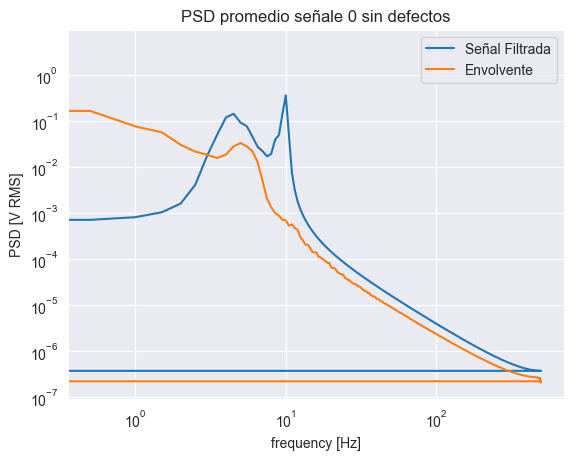

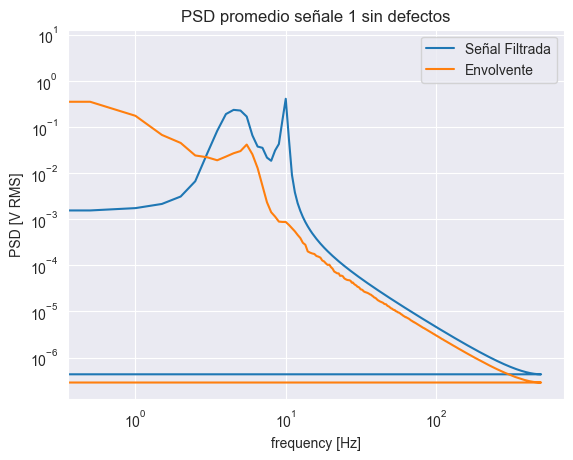

In [135]:

for i, (psd, amp ,freq) in enumerate(zip(psd_signal_mean[:2], psd_amp_mean[:2],freqs[:2])):

    plt.loglog(freq,psd, label = 'Señal Filtrada')
    plt.loglog(freq, amp, label = 'Envolvente')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD promedio señale {i} sin defectos')
    plt.legend()
    plt.show()





In [136]:
psd_all_signal = []
psd_all_amp = []

frequency = []

for df in frames_cd:
    x = df['Filtered Signal'].values
    y = df['Amplitude'].values
    
    f, xx = ffts(x)
    _, yy = ffts(y)

    psd_all_signal.append(xx)
    psd_all_amp.append(yy)
    frequency.append(f)

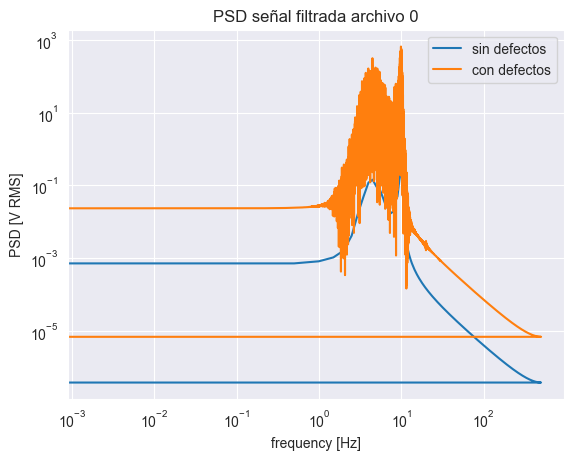

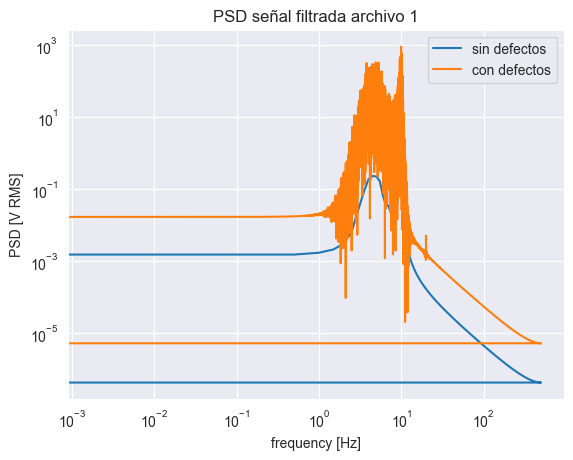

In [139]:
iterables = zip(psd_signal_mean[:2], psd_all_signal[:2], psd_amp_mean[:2], psd_all_amp[:2],freqs[:2], frequency[:2])

for i, (psd_mean, psd_all, amp_mean, amp_all, freq1, freq2) in enumerate(iterables):
    plt.figure
    plt.loglog(freq1,psd_mean, label = 'sin defectos')
    plt.loglog(freq2, psd_all, label = 'con defectos')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD señal filtrada archivo {i}')
    plt.legend()
    plt.show()

Para hacer la psd más smooth se tienen que tomar las mismas ventanas de 2000 pts que en la sin defectos y con eso debería salir. Lo que según yo, es lo mismo que hacer welch con la señal completa a 2000 pts, pero eso queda para la consuelo del lunes.